#Partiendo de la limpieza de datos realizada previamente, se utiliza LSTM para predecir la producción de pozos de petroleo.

###Pozos a predecir:
158364, 160211, 160332, 160789, 160810, 160814, 161451, 162200, 162405, 162955, 163237, 163942





In [ ]:
import math
import itertools
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.max_columns', None)

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#dataset = pd.read_csv("/content/drive/MyDrive/Trabajo profesional/Code/data/prod_norm_2024-05-27_03:42:59.csv", index_col=0)
dataset = pd.read_csv("/content/drive/MyDrive/Trabajo profesional/Code/data/prod_clean_2024-05-13_17:08:31.csv", index_col=0)

dataset = dataset[dataset['anio'] >= 2014]

# Seleccionar características relevantes
features = ['prod_pet', 'anio', 'mes', 'idpozo', 'prod_gas', 'prod_agua', 'tef', 'coordenadax', 'coordenaday', 'cota', 'pet_inicial', 'gas_inicial', 'agua_inicial']

# Filtrar características
data = dataset[features]

# Creacion de una nueva columna 'date' combinando 'anio' y 'mes' para representar la fecha
data['date'] = pd.to_datetime(data['anio'].astype(str) + '-' + data['mes'].astype(str), format='%Y-%m')

data.drop(['mes', 'anio'], axis=1, inplace=True)

# Conversion de la columna 'date' a "datetime type"
data['date'] = pd.to_datetime(data['date'])

# Definicion de un dia de referencia inicial (Es la primera fecha desde la que se filtro previamente).
reference_date = pd.Timestamp('2014-01-01')

# Calculo del numero de meses desde la referencia para cada date.
data['date_numeric'] = (data['date'].dt.year - reference_date.year) * 12 + data['date'].dt.month - reference_date.month + 1

data.drop(['date'], axis=1, inplace=True)

filtered_data_one_id = data[data['idpozo'] == 158364]

filtered_data_one_id.drop(['idpozo'], axis=1, inplace=True)




Mounted at /content/drive


<ipython-input-1-69024501b089>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['anio'].astype(str) + '-' + data['mes'].astype(str), format='%Y-%m')
<ipython-input-1-69024501b089>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['mes', 'anio'], axis=1, inplace=True)
<ipython-input-1-69024501b089>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

1/1 [==============================] - 0s 258ms/step

1/1 [==============================] - 0s 223ms/step

1/1 [==============================] - 0s 337ms/step

1/1 [==============================] - 0s 222ms/step

1/1 [==============================] - 0s 199ms/step

1/1 [==============================] - 0s 230ms/step

1/1 [==============================] - 0s 190ms/step

1/1 [==============================] - 0s 189ms/step

1/1 [==============================] - 0s 173ms/step

1/1 [==============================] - 0s 197ms/step

1/1 [==============================] - 0s 232ms/step

1/1 [==============================] - 0s 188ms/step

1/1 [==============================] - 0s 172ms/step

1/1 [==============================] - 0s 178ms/step

1/1 [==============================] - 0s 181ms/step

1/1 [==============================] - 0s 188ms/step

1/1 [==============================] - 0s 195ms/step

1/1 [==============================] - 0s 231ms/step

1/1 [=======================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 172ms/step
Error Cuadrático Medio: 1971.595921788593
Error Absoluto Medio: 30.86164306640626


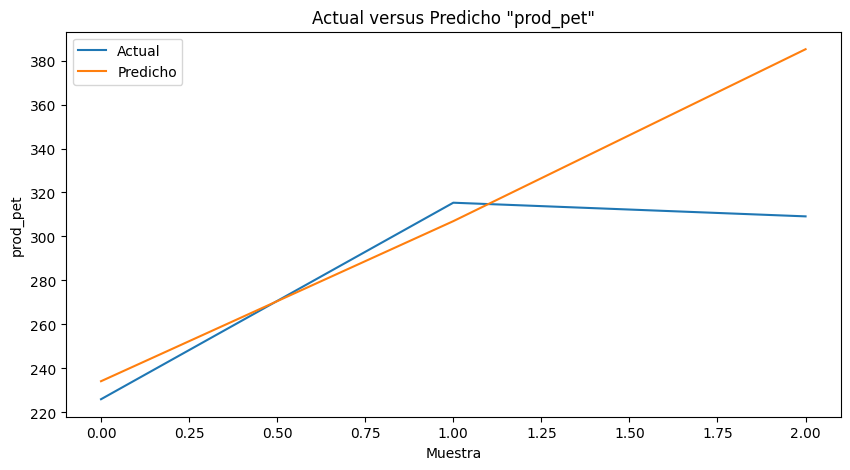

1/1 [==============================] - 0s 22ms/step
Predicciones para valores futuros de prod_pet: [368.7681  353.80774 350.8081  339.95197 329.87595 319.7303  310.42374
 301.5772 ]


In [ ]:
# 50 Trials - mse

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation
import matplotlib.pyplot as plt
from hyperopt import hp, fmin, tpe, Trials

# "X" contiene los features
X = filtered_data_one_id[['tef', 'coordenadax', 'coordenaday', 'cota', 'pet_inicial', 'gas_inicial', 'agua_inicial', 'date_numeric']]

# "y" contiene la columna que es la variable objetivo a predecir.
y = filtered_data_one_id['prod_pet']

# Escalar las características entre 0 y 1
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Escalar la variable objetivo entre 0 y 1
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Longitud de la secuencia
seq_length = 3

# Función para crear secuencias para LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequence = data[i:i + seq_length]
        sequences.append(sequence)
    return np.array(sequences)

# Crear secuencias para LSTM
X_sequences = create_sequences(X_scaled, seq_length)

# Ajustar "y" para que coincida con las secuencias
y_adjusted = y_scaled[seq_length - 1:]

# Dividir los datos en conjuntos de entrenamiento y prueba
#X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_adjusted, test_size=0.2, random_state=42, shuffle=False)
# Calcular el índice de corte para los últimos 3 valores (121, 122 y 123)
test_size = 3
split_index = len(X_sequences) - test_size

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test = X_sequences[:split_index], X_sequences[split_index:]
y_train, y_test = y_adjusted[:split_index], y_adjusted[split_index:]


# Definir el espacio de búsqueda de hiperparámetros
space = {
    'batch_size': hp.choice('batch_size', [16, 32, 64, 128]),
    'epochs': hp.choice('epochs', [100, 200, 300, 400])
}

# Función objetivo para minimizar (en este caso, el error cuadrático medio)
def objective(params):
    model = Sequential([
        LSTM(100, activation='relu', input_shape=(seq_length, X_train.shape[2])),
        Dense(1),
        Activation('relu')  # Asegurar que las predicciones sean no negativas
    ])
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], validation_data=(X_test, y_test), verbose=0)
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred)
    return mse

# Ejecutar la búsqueda de hiperparámetros
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=50, trials=trials)

# Obtener los mejores hiperparámetros
best_batch_size = [16, 32, 64, 128][best['batch_size']]
best_epochs = [100, 200, 300, 400][best['epochs']]

print(f'Mejor tamaño de lote: {best_batch_size}')
print(f'Mejor cantidad de épocas: {best_epochs}')

# Construir el modelo final con los mejores hiperparámetros
model = Sequential([
    LSTM(100, activation='relu', input_shape=(seq_length, X_train.shape[2])),
    Dense(1),
    Activation('relu')  # Asegurar que las predicciones sean no negativas
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, validation_data=(X_test, y_test), verbose=1)

model.save("/content/drive/MyDrive/Trabajo profesional/Code/LSTM/Modelos/158364/best_lstm_model_158364-50trials.h5")

# Predecir en el conjunto de prueba
y_pred_scaled = model.predict(X_test)

# Inversión del escalado para obtener las predicciones reales
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Calculo de métricas de error
mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred)
mae = mean_absolute_error(scaler_y.inverse_transform(y_test), y_pred)

print(f'Error Cuadrático Medio: {mse}')
print(f'Error Absoluto Medio: {mae}')

# Graficar los valores predichos vs los valores reales
plt.figure(figsize=(10, 5))
plt.plot(scaler_y.inverse_transform(y_test), label='Actual')
plt.plot(y_pred, label='Predicho')
plt.xlabel('Muestra')
plt.ylabel('prod_pet')
plt.title('Actual versus Predicho "prod_pet"')
plt.legend()
plt.show()
plt.savefig('/content/drive/MyDrive/Trabajo profesional/Code/LSTM/158364/best_lstm_model_158364-50trials.png')

# Predecir "prod_pet" para los siguientes valores futuros de "date_numeric"
future_date_numeric_values = [121, 122, 123, 124, 125, 126, 127, 128]

# Crear un DataFrame con los valores futuros y placeholders para las demás características
future_data = pd.DataFrame({
    'tef': [filtered_data_one_id['tef'].iloc[-1]] * len(future_date_numeric_values),
    'coordenadax': [filtered_data_one_id['coordenadax'].iloc[-1]] * len(future_date_numeric_values),
    'coordenaday': [filtered_data_one_id['coordenaday'].iloc[-1]] * len(future_date_numeric_values),
    'cota': [filtered_data_one_id['cota'].iloc[-1]] * len(future_date_numeric_values),
    'pet_inicial': [filtered_data_one_id['pet_inicial'].iloc[-1]] * len(future_date_numeric_values),
    'gas_inicial': [filtered_data_one_id['gas_inicial'].iloc[-1]] * len(future_date_numeric_values),
    'agua_inicial': [filtered_data_one_id['agua_inicial'].iloc[-1]] * len(future_date_numeric_values),
    'date_numeric': future_date_numeric_values
})

# Escalar los datos futuros
scaled_future_data = scaler_X.transform(future_data)

# Crear secuencias para LSTM usando los datos futuros escalados
last_sequence = X_scaled[-seq_length:]
future_sequences = []
for i in range(len(future_date_numeric_values)):
    new_sequence = np.append(last_sequence[1:], [scaled_future_data[i]], axis=0)
    future_sequences.append(new_sequence)
    last_sequence = new_sequence
future_sequences = np.array(future_sequences)

# Hacer predicciones (escaladas - no valores reales)
predictions_scaled = model.predict(future_sequences)

# Inversión del escalado para obtener las predicciones reales
predictions = scaler_y.inverse_transform(predictions_scaled)

print("Predicciones para valores futuros de prod_pet:", predictions.flatten())


Valores reales de prod_pet para date_numeric 121, 122 y 123: [225.99 315.35 309.14]
Valores predichos de prod_pet para date_numeric 121, 122 y 123: [368.7681  353.80774 350.8081 ]


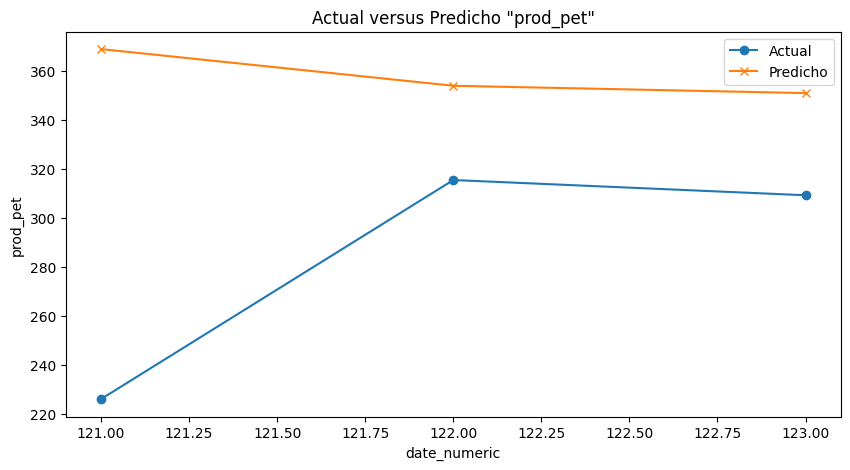

In [ ]:
import matplotlib.pyplot as plt

# Filtrar los datos de prueba para los valores de date_numeric 121, 122 y 123
test_data = filtered_data_one_id[filtered_data_one_id['date_numeric'].isin([121, 122, 123])]

# Extraer la columna de 'prod_pet' para los valores de date_numeric 121, 122 y 123
real_values = test_data['prod_pet'].values

# Obtener las predicciones para los valores de date_numeric 121, 122 y 123
# Aquí 'predictions' se supone que contiene las predicciones de los valores futuros
predicted_values = predictions[:3].flatten()

# Imprimir los valores reales de prod_pet para date_numeric 121, 122 y 123
print("Valores reales de prod_pet para date_numeric 121, 122 y 123:", real_values)

# Imprimir los valores predichos de prod_pet para date_numeric 121, 122 y 123
print("Valores predichos de prod_pet para date_numeric 121, 122 y 123:", predicted_values)

# Graficar los valores reales vs los valores predichos
plt.figure(figsize=(10, 5))
plt.plot([121, 122, 123], real_values, label='Actual', marker='o')
plt.plot([121, 122, 123], predicted_values, label='Predicho', marker='x')
plt.xlabel('date_numeric')
plt.ylabel('prod_pet')
plt.title('Actual versus Predicho "prod_pet"')
plt.legend()
plt.show()
plt.savefig('/content/drive/MyDrive/Trabajo profesional/Code/LSTM/158364/best_lstm_model_158364-50trials-121-122-123-comparasion-actual-vs-predicho.png')


1/1 [==============================] - 0s 238ms/step

1/1 [==============================] - 0s 280ms/step

1/1 [==============================] - 0s 189ms/step

1/1 [==============================] - 0s 176ms/step

  4%|▍         | 4/100 [01:18<28:40, 17.93s/trial, best loss: 708.1348325783285]

1/1 [==============================] - 0s 189ms/step

  5%|▌         | 5/100 [01:24<21:27, 13.55s/trial, best loss: 708.1348325783285]

1/1 [==============================] - 0s 189ms/step

1/1 [==============================] - 0s 173ms/step

1/1 [==============================] - 0s 175ms/step

1/1 [==============================] - 0s 216ms/step

1/1 [==============================] - 0s 190ms/step

1/1 [==============================] - 0s 173ms/step

1/1 [==============================] - 0s 202ms/step

1/1 [==============================] - 0s 171ms/step

1/1 [==============================] - 0s 183ms/step

1/1 [==============================] - 0s 198ms/step

1/1 [==============================] - 0s 179ms/step

1/1 [==============================] - 0s 173ms/step

1/1 [==============================] - 0s 179ms/step

1/1 [==============================] - 0s 188ms/step

1/1 [==============================] - 0s 178ms/step

1/1 [==============================] - 0s 269ms/step

1/1 [==============================] - 0s 188ms/step

1/1 [==============================] - 0s 178ms/step

1/1 [=======================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 182ms/step
Error Cuadrático Medio: 6535.977624784079
Error Absoluto Medio: 67.86698771158854


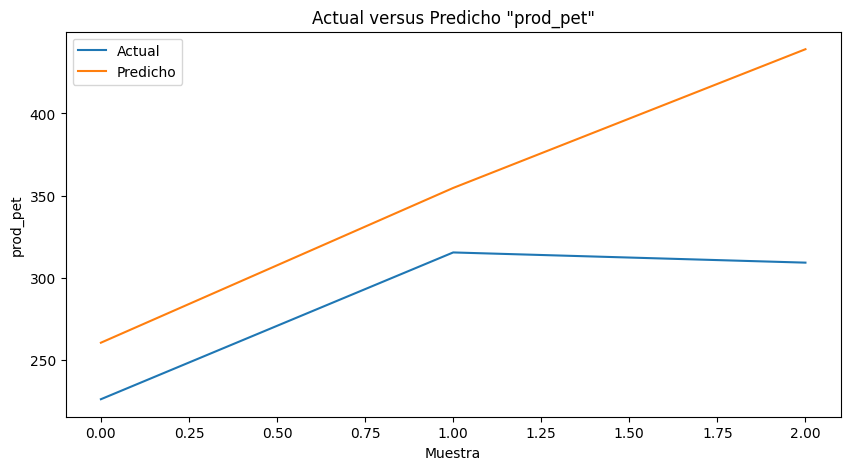

1/1 [==============================] - 0s 22ms/step
Predicciones para valores futuros de prod_pet: [434.95068 432.25082 432.7004  426.13538 420.2041  414.50137 408.9525
 403.55585]


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation
import matplotlib.pyplot as plt
from hyperopt import hp, fmin, tpe, Trials
import tensorflow as tf

# Establecer una semilla aleatoria para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

# "X" contiene los features
X = filtered_data_one_id[['tef', 'coordenadax', 'coordenaday', 'cota', 'pet_inicial', 'gas_inicial', 'agua_inicial', 'date_numeric']]

# "y" contiene la columna que es la variable objetivo a predecir.
y = filtered_data_one_id['prod_pet']

# Escalar las características entre 0 y 1
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Escalar la variable objetivo entre 0 y 1
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Longitud de la secuencia
seq_length = 3

# Función para crear secuencias para LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequence = data[i:i + seq_length]
        sequences.append(sequence)
    return np.array(sequences)

# Crear secuencias para LSTM
X_sequences = create_sequences(X_scaled, seq_length)

# Ajustar "y" para que coincida con las secuencias
y_adjusted = y_scaled[seq_length - 1:]

# Dividir los datos en conjuntos de entrenamiento y prueba
#X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_adjusted, test_size=0.2, random_state=42, shuffle=False)
# Calcular el índice de corte para los últimos 3 valores (121, 122 y 123)
test_size = 3
split_index = len(X_sequences) - test_size

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test = X_sequences[:split_index], X_sequences[split_index:]
y_train, y_test = y_adjusted[:split_index], y_adjusted[split_index:]

# Definir el espacio de búsqueda de hiperparámetros
space = {
    'batch_size': hp.choice('batch_size', [16, 32, 64, 128]),
    'epochs': hp.choice('epochs', [100, 200, 300, 400])
}

# Función objetivo para minimizar (en este caso, la combinación de MSE y MAE)
def objective(params):
    model = Sequential([
        LSTM(100, activation='relu', input_shape=(seq_length, X_train.shape[2])),
        Dense(1),
        Activation('relu')  # Asegurar que las predicciones sean no negativas
    ])
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], validation_data=(X_test, y_test), verbose=0)
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Calcular el MSE y MAE
    mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred)
    mae = mean_absolute_error(scaler_y.inverse_transform(y_test), y_pred)

    # Combinar MSE y MAE en una única métrica
    combined_metric = 0.5 * mse + 0.5 * mae
    return combined_metric

# Ejecutar la búsqueda de hiperparámetros
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials)  # Aumentar max_evals

# Obtener los mejores hiperparámetros
best_batch_size = [16, 32, 64, 128][best['batch_size']]
best_epochs = [100, 200, 300, 400][best['epochs']]

print(f'Mejor tamaño de lote: {best_batch_size}')
print(f'Mejor cantidad de épocas: {best_epochs}')

# Construir el modelo final con los mejores hiperparámetros
model = Sequential([
    LSTM(100, activation='relu', input_shape=(seq_length, X_train.shape[2])),
    Dense(1),
    Activation('relu')  # Asegurar que las predicciones sean no negativas
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, validation_data=(X_test, y_test), verbose=1)

model.save("/content/drive/MyDrive/Trabajo profesional/Code/LSTM/Modelos/158364/best_lstm_model_158364_mse_mae.h5")

# Predecir en el conjunto de prueba
y_pred_scaled = model.predict(X_test)

# Inversión del escalado para obtener las predicciones reales
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Calculo de métricas de error
mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred)
mae = mean_absolute_error(scaler_y.inverse_transform(y_test), y_pred)

print(f'Error Cuadrático Medio: {mse}')
print(f'Error Absoluto Medio: {mae}')

# Graficar los valores predichos vs los valores reales
plt.figure(figsize=(10, 5))
plt.plot(scaler_y.inverse_transform(y_test), label='Actual')
plt.plot(y_pred, label='Predicho')
plt.xlabel('Muestra')
plt.ylabel('prod_pet')
plt.title('Actual versus Predicho "prod_pet"')
plt.legend()
plt.show()
plt.savefig('/content/drive/MyDrive/Trabajo profesional/Code/LSTM/158364/best_lstm_model_158364_mse_mae.png')

# Predecir "prod_pet" para los siguientes valores futuros de "date_numeric"
future_date_numeric_values = [121, 122, 123, 124, 125, 126, 127, 128]

# Crear un DataFrame con los valores futuros y placeholders para las demás características
future_data = pd.DataFrame({
    'tef': [filtered_data_one_id['tef'].iloc[-1]] * len(future_date_numeric_values),
    'coordenadax': [filtered_data_one_id['coordenadax'].iloc[-1]] * len(future_date_numeric_values),
    'coordenaday': [filtered_data_one_id['coordenaday'].iloc[-1]] * len(future_date_numeric_values),
    'cota': [filtered_data_one_id['cota'].iloc[-1]] * len(future_date_numeric_values),
    'pet_inicial': [filtered_data_one_id['pet_inicial'].iloc[-1]] * len(future_date_numeric_values),
    'gas_inicial': [filtered_data_one_id['gas_inicial'].iloc[-1]] * len(future_date_numeric_values),
    'agua_inicial': [filtered_data_one_id['agua_inicial'].iloc[-1]] * len(future_date_numeric_values),
    'date_numeric': future_date_numeric_values
})

# Escalar los datos futuros
scaled_future_data = scaler_X.transform(future_data)

# Crear secuencias para LSTM usando los datos futuros escalados
last_sequence = X_scaled[-seq_length:]
future_sequences = []
for i in range(len(future_date_numeric_values)):
    new_sequence = np.append(last_sequence[1:], [scaled_future_data[i]], axis=0)
    future_sequences.append(new_sequence)
    last_sequence = new_sequence
future_sequences = np.array(future_sequences)

# Hacer predicciones (escaladas - no valores reales)
predictions_scaled = model.predict(future_sequences)

# Inversión del escalado para obtener las predicciones reales
predictions = scaler_y.inverse_transform(predictions_scaled)

print("Predicciones para valores futuros de prod_pet:", predictions.flatten())


Valores reales de prod_pet para date_numeric 121, 122 y 123: [225.99 315.35 309.14]
Valores predichos de prod_pet para date_numeric 121, 122 y 123: [434.95068 432.25082 432.7004 ]


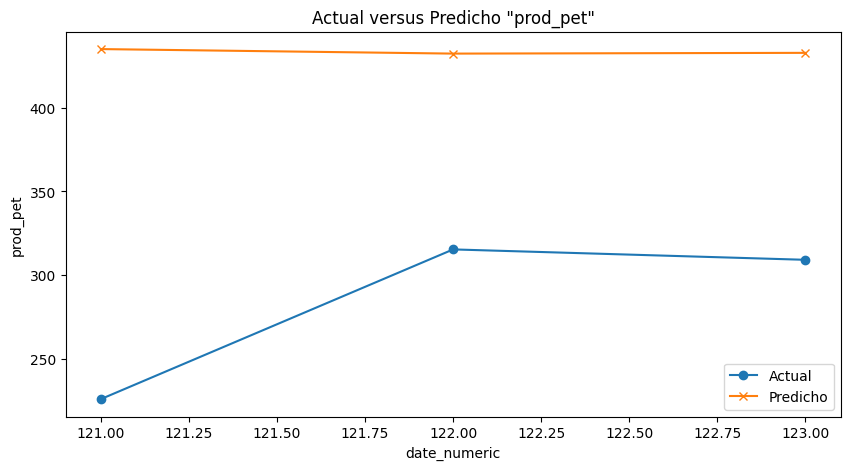

In [ ]:
import matplotlib.pyplot as plt

# Filtrar los datos de prueba para los valores de date_numeric 121, 122 y 123
test_data = filtered_data_one_id[filtered_data_one_id['date_numeric'].isin([121, 122, 123])]

# Extraer la columna de 'prod_pet' para los valores de date_numeric 121, 122 y 123
real_values = test_data['prod_pet'].values

# Obtener las predicciones para los valores de date_numeric 121, 122 y 123
# Aquí 'predictions' se supone que contiene las predicciones de los valores futuros
predicted_values = predictions[:3].flatten()

# Imprimir los valores reales de prod_pet para date_numeric 121, 122 y 123
print("Valores reales de prod_pet para date_numeric 121, 122 y 123:", real_values)

# Imprimir los valores predichos de prod_pet para date_numeric 121, 122 y 123
print("Valores predichos de prod_pet para date_numeric 121, 122 y 123:", predicted_values)

# Graficar los valores reales vs los valores predichos
plt.figure(figsize=(10, 5))
plt.plot([121, 122, 123], real_values, label='Actual', marker='o')
plt.plot([121, 122, 123], predicted_values, label='Predicho', marker='x')
plt.xlabel('date_numeric')
plt.ylabel('prod_pet')
plt.title('Actual versus Predicho "prod_pet"')
plt.legend()
plt.show()
plt.savefig('/content/drive/MyDrive/Trabajo profesional/Code/LSTM/158364/best_lstm_model_158364_mse_mae-121-122-123-actualvspredicted.png')

1/1 [==============================] - 0s 180ms/step

1/1 [==============================] - 0s 200ms/step

1/1 [==============================] - 0s 177ms/step

1/1 [==============================] - 0s 186ms/step

1/1 [==============================] - 0s 187ms/step

1/1 [==============================] - 0s 277ms/step

1/1 [==============================] - 0s 178ms/step

1/1 [==============================] - 0s 192ms/step

1/1 [==============================] - 0s 290ms/step

1/1 [==============================] - 0s 207ms/step

1/1 [==============================] - 0s 187ms/step

1/1 [==============================] - 0s 219ms/step

1/1 [==============================] - 0s 183ms/step

1/1 [==============================] - 0s 187ms/step

1/1 [==============================] - 0s 188ms/step

1/1 [==============================] - 0s 182ms/step

1/1 [==============================] - 0s 186ms/step

1/1 [==============================] - 0s 202ms/step

1/1 [=======================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 280ms/step
Error Cuadrático Medio: 3244.9854894762407
Error Absoluto Medio: 48.53615681966145


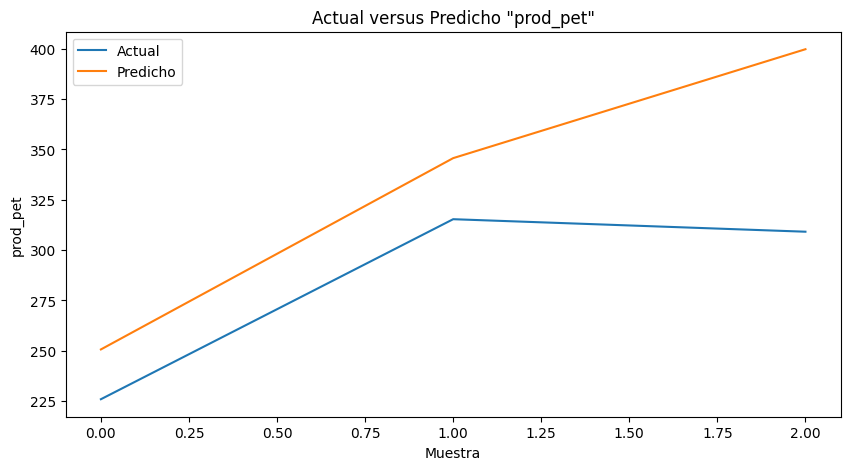

1/1 [==============================] - 0s 21ms/step
Predicciones para valores futuros de prod_pet: [400.05014 394.3745  393.15897 383.9509  374.8119  365.7411  357.24133
 349.0208 ]


In [ ]:
# Con 100 Trials

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation
import matplotlib.pyplot as plt
from hyperopt import hp, fmin, tpe, Trials

# "X" contiene los features
X = filtered_data_one_id[['tef', 'coordenadax', 'coordenaday', 'cota', 'pet_inicial', 'gas_inicial', 'agua_inicial', 'date_numeric']]

# "y" contiene la columna que es la variable objetivo a predecir.
y = filtered_data_one_id['prod_pet']

# Escalar las características entre 0 y 1
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Escalar la variable objetivo entre 0 y 1
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Longitud de la secuencia
seq_length = 3

# Función para crear secuencias para LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequence = data[i:i + seq_length]
        sequences.append(sequence)
    return np.array(sequences)

# Crear secuencias para LSTM
X_sequences = create_sequences(X_scaled, seq_length)

# Ajustar "y" para que coincida con las secuencias
y_adjusted = y_scaled[seq_length - 1:]

# Dividir los datos en conjuntos de entrenamiento y prueba
#X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_adjusted, test_size=0.2, random_state=42, shuffle=False)
# Calcular el índice de corte para los últimos 3 valores (121, 122 y 123)
test_size = 3
split_index = len(X_sequences) - test_size

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test = X_sequences[:split_index], X_sequences[split_index:]
y_train, y_test = y_adjusted[:split_index], y_adjusted[split_index:]


# Definir el espacio de búsqueda de hiperparámetros
space = {
    'batch_size': hp.choice('batch_size', [16, 32, 64, 128]),
    'epochs': hp.choice('epochs', [100, 200, 300, 400])
}

# Función objetivo para minimizar (en este caso, el error cuadrático medio)
def objective(params):
    model = Sequential([
        LSTM(100, activation='relu', input_shape=(seq_length, X_train.shape[2])),
        Dense(1),
        Activation('relu')  # Asegurar que las predicciones sean no negativas
    ])
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], validation_data=(X_test, y_test), verbose=0)
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred)
    return mse

# Ejecutar la búsqueda de hiperparámetros
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=50, trials=trials)

# Obtener los mejores hiperparámetros
best_batch_size = [16, 32, 64, 128][best['batch_size']]
best_epochs = [100, 200, 300, 400][best['epochs']]

print(f'Mejor tamaño de lote: {best_batch_size}')
print(f'Mejor cantidad de épocas: {best_epochs}')

# Construir el modelo final con los mejores hiperparámetros
model = Sequential([
    LSTM(100, activation='relu', input_shape=(seq_length, X_train.shape[2])),
    Dense(1),
    Activation('relu')  # Asegurar que las predicciones sean no negativas
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, validation_data=(X_test, y_test), verbose=1)

model.save("/content/drive/MyDrive/Trabajo profesional/Code/LSTM/Modelos/158364/best_lstm_model_158364_100-trials.h5")

# Predecir en el conjunto de prueba
y_pred_scaled = model.predict(X_test)

# Inversión del escalado para obtener las predicciones reales
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Calculo de métricas de error
mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred)
mae = mean_absolute_error(scaler_y.inverse_transform(y_test), y_pred)

print(f'Error Cuadrático Medio: {mse}')
print(f'Error Absoluto Medio: {mae}')

# Graficar los valores predichos vs los valores reales
plt.figure(figsize=(10, 5))
plt.plot(scaler_y.inverse_transform(y_test), label='Actual')
plt.plot(y_pred, label='Predicho')
plt.xlabel('Muestra')
plt.ylabel('prod_pet')
plt.title('Actual versus Predicho "prod_pet"')
plt.legend()
plt.show()
plt.savefig('/content/drive/MyDrive/Trabajo profesional/Code/LSTM/158364/best_lstm_model_158364_100trials.png')

# Predecir "prod_pet" para los siguientes valores futuros de "date_numeric"
future_date_numeric_values = [121, 122, 123, 124, 125, 126, 127, 128]

# Crear un DataFrame con los valores futuros y placeholders para las demás características
future_data = pd.DataFrame({
    'tef': [filtered_data_one_id['tef'].iloc[-1]] * len(future_date_numeric_values),
    'coordenadax': [filtered_data_one_id['coordenadax'].iloc[-1]] * len(future_date_numeric_values),
    'coordenaday': [filtered_data_one_id['coordenaday'].iloc[-1]] * len(future_date_numeric_values),
    'cota': [filtered_data_one_id['cota'].iloc[-1]] * len(future_date_numeric_values),
    'pet_inicial': [filtered_data_one_id['pet_inicial'].iloc[-1]] * len(future_date_numeric_values),
    'gas_inicial': [filtered_data_one_id['gas_inicial'].iloc[-1]] * len(future_date_numeric_values),
    'agua_inicial': [filtered_data_one_id['agua_inicial'].iloc[-1]] * len(future_date_numeric_values),
    'date_numeric': future_date_numeric_values
})

# Escalar los datos futuros
scaled_future_data = scaler_X.transform(future_data)

# Crear secuencias para LSTM usando los datos futuros escalados
last_sequence = X_scaled[-seq_length:]
future_sequences = []
for i in range(len(future_date_numeric_values)):
    new_sequence = np.append(last_sequence[1:], [scaled_future_data[i]], axis=0)
    future_sequences.append(new_sequence)
    last_sequence = new_sequence
future_sequences = np.array(future_sequences)

# Hacer predicciones (escaladas - no valores reales)
predictions_scaled = model.predict(future_sequences)

# Inversión del escalado para obtener las predicciones reales
predictions = scaler_y.inverse_transform(predictions_scaled)

print("Predicciones para valores futuros de prod_pet:", predictions.flatten())


Valores reales de prod_pet para date_numeric 121, 122 y 123: [225.99 315.35 309.14]
Valores predichos de prod_pet para date_numeric 121, 122 y 123: [400.05014 394.3745  393.15897]


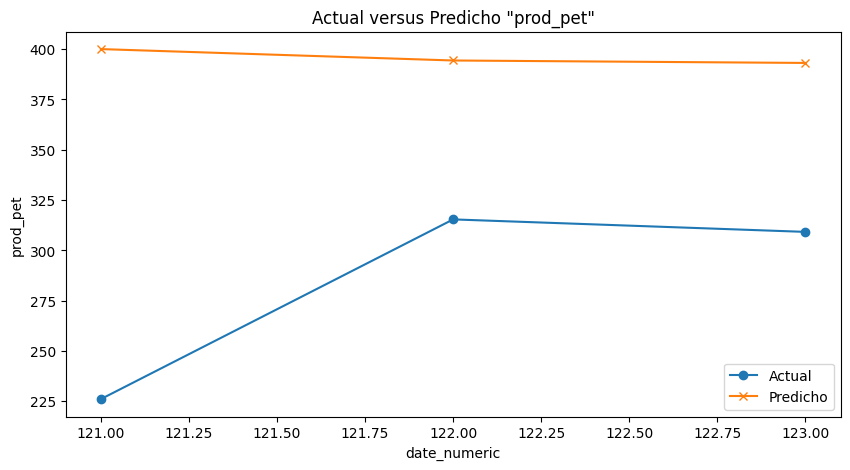

In [ ]:
import matplotlib.pyplot as plt

# Filtrar los datos de prueba para los valores de date_numeric 121, 122 y 123
test_data = filtered_data_one_id[filtered_data_one_id['date_numeric'].isin([121, 122, 123])]

# Extraer la columna de 'prod_pet' para los valores de date_numeric 121, 122 y 123
real_values = test_data['prod_pet'].values

# Obtener las predicciones para los valores de date_numeric 121, 122 y 123
# Aquí 'predictions' se supone que contiene las predicciones de los valores futuros
predicted_values = predictions[:3].flatten()

# Imprimir los valores reales de prod_pet para date_numeric 121, 122 y 123
print("Valores reales de prod_pet para date_numeric 121, 122 y 123:", real_values)

# Imprimir los valores predichos de prod_pet para date_numeric 121, 122 y 123
print("Valores predichos de prod_pet para date_numeric 121, 122 y 123:", predicted_values)

# Graficar los valores reales vs los valores predichos
plt.figure(figsize=(10, 5))
plt.plot([121, 122, 123], real_values, label='Actual', marker='o')
plt.plot([121, 122, 123], predicted_values, label='Predicho', marker='x')
plt.xlabel('date_numeric')
plt.ylabel('prod_pet')
plt.title('Actual versus Predicho "prod_pet"')
plt.legend()
plt.show()
plt.savefig('/content/drive/MyDrive/Trabajo profesional/Code/LSTM/158364/best_lstm_model_158364_100trials-121-122-123-actualvspredicted.png')